In [ ]:
import torch
torch.__version__

#Sentiment Analysis using Countinous BOW

##Flow of Program
0. Import important Libraries
1. Prepare Data (Convert into Tensor,Batches)
2. Build a model
3. Pick a loss function and Optimizer
4. Make Train and Evaluation Loop function
5. Start Training Loop
6. visualize your model
7. Testing Model with New Sentences (Sentiment Analysis)

###0. Import important Libraries

In [ ]:
!pip install datasets

In [ ]:
!pip install torchtext==0.15.0 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!pip install torch  --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import torch
import torchtext # import the installed library

print(torch.__version__)
print(torchtext.__version__)

2.0.0+cu118
0.15.0+cpu


In [ ]:
import collections
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

###1. Prepare your data

1.1 Loading Datasets<br>
1.2 Tokenize your data<br>
1.3 Creating Validation Data splits<br>
1.4 creating Vocabulary<br>
1.5 Numericalizing Data<br>
1.6 Converting into Tensor<br>
1.7 Creating data Batch Loader

####1.1 Loading Dataset

In [ ]:
train_data,test_data=datasets.load_dataset("imdb",split=["train","test"])

In [ ]:
train_data,test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [ ]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [ ]:
train_data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [ ]:
test_data[24000]

{'text': "The movie is about a girl who's not going to a bonfire only because she's baby-sitting that night. Nothing weird about that, right? Until ... The phone rings. Until ... The phone rings again. And again ... And again. Those are not some stupid prank calls. This is for real. If you wanna see how the girl reacts, just watch the movie.<br /><br />Great atmosphere filled with scary sounds. Very well performed by young Camilla Belle who got the lead role. I see in her some great potential to become a good actress. This is more than only a decent thriller, I have no idea why it's so underrated. Anyway, on my opinion this movie deserves more than only 4/10. 24% of all voters rated the movie with 1. Get serious, people. You couldn't get a better thriller for a title like this.",
 'label': 1}

####1.2 Tokenize your data(Tokeization)

In [ ]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [ ]:
tokenizer("Hello world my name is anand,How are you doing?")

['hello',
 'world',
 'my',
 'name',
 'is',
 'anand',
 ',',
 'how',
 'are',
 'you',
 'doing',
 '?']

In [ ]:
def tokenize_example(example,tokenizer,max_length):
  tokens=tokenizer(example['text'])[:max_length]
  return {"tokens":tokens}

In [ ]:
max_length=256

train_data=train_data.map(
    tokenize_example,
    fn_kwargs={"tokenizer":tokenizer,"max_length":max_length}
)
test_data=test_data.map(
    tokenize_example,
    fn_kwargs={"tokenizer":tokenizer,"max_length":max_length}
)

In [ ]:
train_data,test_data

(Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 25000
 }))

In [ ]:
train_data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [ ]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

####1.3 Creating Validation Data Splits

**train,test,valid**

In [ ]:
test_size=0.25
train_valid_data=train_data.train_test_split(test_size=test_size)
train_data=train_valid_data["train"]
valid_data=train_valid_data["test"]

In [ ]:
train_data,valid_data,test_data

(Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 18750
 }),
 Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 6250
 }),
 Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 25000
 }))

#### 1.4 Creating Vocabulary from train_data

In [ ]:
min_freq=5
special_tokens=["<unk>","<pad>"]
vocab=torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [ ]:
len(vocab)

21578

In [ ]:
vocab.get_itos()[:10]

['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'"]

In [ ]:
vocab["and"]

6

In [ ]:
unk_index=vocab["<unk>"]
pad_index=vocab["<pad>"]

In [ ]:
unk_index,pad_index

(0, 1)

In [ ]:
"Chache" in vocab

False

In [ ]:
vocab["chache"] #Getting eror because this word is not in vocab but we dont want error we want it as <unk> token index as 0

In [ ]:
vocab.set_default_index(
    unk_index
)

In [ ]:
vocab["chache"]

0

####1.5 Numericalizing Data

In [ ]:
vocab.lookup_indices(["hello","world","jkbabduibuobd","<pad>","<unk>"])

[5028, 191, 0, 1, 0]

In [ ]:
def numericalize_example(example,vocab):
  id=vocab.lookup_indices(example["tokens"])
  return{"id":id}

In [ ]:
train_data=train_data.map(numericalize_example,fn_kwargs={"vocab":vocab})
valid_data=valid_data.map(numericalize_example,fn_kwargs={"vocab":vocab})
test_data=test_data.map(numericalize_example,fn_kwargs={"vocab":vocab})

Map:   0%|          | 0/18750 [00:00<?, ? examples/s]

Map:   0%|          | 0/6250 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
train_data,valid_data,test_data

(Dataset({
     features: ['text', 'label', 'tokens', 'id'],
     num_rows: 18750
 }),
 Dataset({
     features: ['text', 'label', 'tokens', 'id'],
     num_rows: 6250
 }),
 Dataset({
     features: ['text', 'label', 'tokens', 'id'],
     num_rows: 25000
 }))

In [ ]:
train_data[0]["id"][0:10]

[52, 170, 1679, 122, 11814, 4, 11, 95, 35, 1267]

In [ ]:
train_data[0]["tokens"][0:10]

['if',
 'another',
 'hitler',
 'ever',
 'arises',
 ',',
 'it',
 'will',
 'be',
 'thanks']

In [ ]:
vocab["i"],vocab["seen"]

(12, 112)

In [ ]:
vocab.lookup_indices(['i', "'", 've', 'seen', 'all', 'kinds', 'of', 'hamlets', '.', 'kenneth'])

[12, 9, 141, 112, 37, 2603, 7, 0, 3, 3225]

In [ ]:
vocab.lookup_tokens([12, 9, 140, 110, 38, 2397, 7, 0, 3, 3581])

['i', "'", 'watching', 'watch', 'at', 'china', 'of', '<unk>', '.', 'existed']

In [ ]:
vocab.get_itos()[0:10]

['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'"]

In [ ]:
vocab[',']

4

####1.6 Convert it to Tensor

In [ ]:
train_data=train_data.with_format(type='torch',columns=["id",'label'])
valid_data=valid_data.with_format(type='torch',columns=["id",'label'])
test_data=test_data.with_format(type='torch',columns=["id",'label'])

In [ ]:
train_data,valid_data,test_data

(Dataset({
     features: ['text', 'label', 'tokens', 'id'],
     num_rows: 18750
 }),
 Dataset({
     features: ['text', 'label', 'tokens', 'id'],
     num_rows: 6250
 }),
 Dataset({
     features: ['text', 'label', 'tokens', 'id'],
     num_rows: 25000
 }))

In [ ]:
train_data[0]['label']

tensor(0)

In [ ]:
train_data[0]['id']

tensor([   52,   170,  1679,   122, 11814,     4,    11,    95,    35,  1267,
           13,   187,     8,  1960,    45,    14,    23,     4,    73,     0,
            2,  1765,  5138,    15,    33,    17,     5, 14993,  5494,  6575,
           44,     2,   348,     3,   247,    44,   936,   145,     5,   429,
            6, 19989,   102,     8,     2,  4328,  1113,    13,     2,  1527,
            4,  7944,    82,    68,  1905,     2,   857,     8,   811,   102,
            4,     6,    33,    68,    31,  1093,    13,     5, 14271,     4,
        15731,     6,  1809,     3,   256,    42,  3847,     2,  5719,     7,
         1679,     9,    16,   552,  8281,    86,     2,  9140,     7,    32,
         3316,     0, 20444,    21,  1892,    86,    95,    35,  3286,    39,
            2,   203,    15,    82,   258,   102,     5,  8361,     4,  1062,
            4,  3527,   133,     3,    33,    17,    99,     5,   493,     0,
            4,     6,     2,   203,    15,    32,  5459,   321, 

In [ ]:
train_data[0].keys()

dict_keys(['label', 'id'])

In [ ]:
vocab.lookup_tokens(train_data[0]["id"][:10].tolist())

['if',
 'another',
 'hitler',
 'ever',
 'arises',
 ',',
 'it',
 'will',
 'be',
 'thanks']

####1.7 Creating Data Batch loader

In [ ]:
def get_collate_fn(pad_index):
  def collate_fn(batch):
    batch_ids=[i["id"] for i in batch]#[batch_size,length] ->[512,]
    batch_ids=nn.utils.rnn.pad_sequence(
        batch_ids,padding_value=pad_index,batch_first=True
    )
    batch_label=[i["label"] for i in batch]
    batch_label=torch.stack(batch_label)
    batch={"batch_ids":batch_ids,"batch_labels":batch_label}
    return batch
  return collate_fn

In [ ]:
def get_data_loader(dataset,batch_size,pad_index,shuffle=False):
  collate_fn=get_collate_fn(pad_index)
  data_loader=torch.utils.data.DataLoader(
      dataset=dataset,
      batch_size=batch_size,
      collate_fn=collate_fn,
      shuffle=shuffle
  )
  return data_loader

In [ ]:
batch_size=512

In [ ]:
train_batch_loader=get_data_loader(train_data,batch_size,pad_index,shuffle=True)
valid_batch_loader=get_data_loader(valid_data,batch_size,pad_index)
test_batch_loader=get_data_loader(test_data,batch_size,pad_index)

In [ ]:
len(train_batch_loader),len(valid_batch_loader),len(test_batch_loader)

(37, 13, 49)

In [ ]:
len(vocab)

21578

###2. Build a Model

In [ ]:
class CBOW(nn.Module):
  def __init__(self,vocab_size,embedding_dim,output_dim,pad_index):
    super().__init__()
    self.embeddings=nn.Embedding(vocab_size,embedding_dim,pad_index)
    self.fc=nn.Linear(embedding_dim,output_dim)

  def forward(self,id):
    #id=[batch_size,seq_length]
    embedded=self.embeddings(id)
    #embedded=[batch_size,seq_length,embedding_dim]
    pooled=embedded.mean(dim=1)
    #pooled=[batch_size,embedding_dim]
    prediction=self.fc(pooled)
    #prediction=[batch_size,output_dim]
    return prediction

In [ ]:
vocab_size=len(vocab)
embedding_dim=300
output_dim=len(train_data.unique("label"))
model=CBOW(vocab_size,embedding_dim,output_dim,pad_index)

In [ ]:
pad_index

1

In [ ]:
model

CBOW(
  (embeddings): Embedding(21578, 300, padding_idx=1)
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 6,474,002 trainable parameters


**Used Pretrained model CloVe for getting embeddings of words**

In [ ]:
vectore=torchtext.vocab.GloVe()

In [ ]:
hello_vector=vectore.get_vecs_by_tokens("India")

In [ ]:
hello_vector.shape

torch.Size([300])

In [ ]:
len(vocab)

21578

In [ ]:
pretrained_embedding=vectore.get_vecs_by_tokens(vocab.get_itos())

In [ ]:
pretrained_embedding.shape

torch.Size([21578, 300])

In [ ]:
model.embeddings.weight

Parameter containing:
tensor([[ 0.3144,  0.1946,  1.9772,  ..., -0.6090,  0.6658,  0.7183],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.4046,  0.2845, -0.0905,  ..., -0.4161,  1.5363,  0.6279],
        ...,
        [-0.5448, -0.0029, -0.3887,  ..., -0.7553,  1.1514, -0.2577],
        [-0.2990,  0.3731,  1.2487,  ...,  0.2754, -0.7335, -0.5250],
        [ 0.4719,  1.6890,  1.2817,  ..., -2.2351, -0.7168,  0.3489]],
       requires_grad=True)

In [ ]:
pretrained_embedding

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.1187, -0.5503, -0.4848,  ...,  0.2006,  0.0301,  0.3918],
        [-0.1503,  0.5624, -0.5622,  ..., -0.4224, -0.6836,  0.0726],
        [ 1.1741, -0.4386,  0.3310,  ...,  0.3193, -0.2292, -0.0887]])

**Replacing the Model embeddings parameters with the GloVe parameters so that training take less time**

In [ ]:
model.embeddings.weight.data=pretrained_embedding

In [ ]:
model.embeddings.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.2720, -0.0620, -0.1884,  ...,  0.1302, -0.1832,  0.1323],
        ...,
        [ 0.1187, -0.5503, -0.4848,  ...,  0.2006,  0.0301,  0.3918],
        [-0.1503,  0.5624, -0.5622,  ..., -0.4224, -0.6836,  0.0726],
        [ 1.1741, -0.4386,  0.3310,  ...,  0.3193, -0.2292, -0.0887]],
       requires_grad=True)

###3. Loss Function and Optimizer

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters())

In [ ]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
model=model.to(device)

In [ ]:
criterion=criterion.to(device)

###4 Build Training and Evaluation Function


In [ ]:
def train(data_loader,model,criterion,optimizer,device):
  model.train()
  epoch_loss=[]
  epoch_acc=[]
  for batch in tqdm.tqdm(data_loader,desc="trainig...."):
    batch_ids=batch["batch_ids"].to(device)
    batch_labels=batch["batch_labels"].to(device)
    prediction=model(batch_ids)
    loss=criterion(prediction,batch_labels)
    accuracy=get_accuracy(prediction,batch_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss.append(loss.item())
    epoch_acc.append(accuracy.item())
  return np.mean(epoch_loss),np.mean(epoch_acc)

In [ ]:
def evaluate(data_loader,model,criterion,device):
  model.eval()
  epoch_loss=[]
  epoch_acc=[]
  with torch.no_grad():
      for batch in tqdm.tqdm(data_loader,desc='Evaluating....'):
            batch_ids=batch["batch_ids"].to(device)
            batch_labels=batch["batch_labels"].to(device)
            prediction=model(batch_ids)
            loss=criterion(prediction,batch_labels)
            accuracy=get_accuracy(prediction,batch_labels)
            epoch_loss.append(loss.item())
            epoch_acc.append(accuracy.item())
      return np.mean(epoch_loss),np.mean(epoch_acc)

In [ ]:
def get_accuracy(prediction,batch_labels):
  batch_size,_ = prediction.shape
  predicted_class=prediction.argmax(dim=-1)
  corrected_prediction=predicted_class.eq(batch_labels).sum()
  accuracy=corrected_prediction / batch_size
  return accuracy

5. Starting Training Loop

In [ ]:
n_epochs=10
best_valid_loss=float("inf")
metrics=collections.defaultdict(list)
for epoch in range(n_epochs):
  train_loss,train_acc=train(
      train_batch_loader,
      model,
      criterion,
      optimizer,
      device)
  valid_loss,valid_acc=evaluate(
      valid_batch_loader,
      model,
      criterion,
      device
  )
  metrics["train_loss"].append(train_loss)
  metrics["train_acc"].append(train_acc)
  metrics["valid_loss"].append(valid_loss)
  metrics["valid_acc"].append(valid_acc)
  if valid_loss < best_valid_loss:
    best_valid_loss=valid_loss
    torch.save(model.state_dict(),"CBOW.pt")
  print(f"Epoch:{epoch}")
  print(f"train loss:{train_loss:.3f},train_acc:{train_acc:.3f}")
  print(f"Valid_loss:{valid_loss:.3f},Valid_Acc:{valid_acc:.3f}")


Evaluating....: 100%|██████████| 13/13 [00:02<00:00,  4.57it/s]


Epoch:0
train loss:0.206,train_acc:0.936
Valid_loss:0.299,Valid_Acc:0.881


Evaluating....: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]


Epoch:1
train loss:0.193,train_acc:0.941
Valid_loss:0.295,Valid_Acc:0.883


Evaluating....: 100%|██████████| 13/13 [00:02<00:00,  5.79it/s]


Epoch:2
train loss:0.180,train_acc:0.946
Valid_loss:0.292,Valid_Acc:0.885


Evaluating....: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]


Epoch:3
train loss:0.169,train_acc:0.951
Valid_loss:0.289,Valid_Acc:0.884


Evaluating....: 100%|██████████| 13/13 [00:02<00:00,  5.81it/s]


Epoch:4
train loss:0.159,train_acc:0.955
Valid_loss:0.287,Valid_Acc:0.886


Evaluating....: 100%|██████████| 13/13 [00:03<00:00,  3.33it/s]


Epoch:5
train loss:0.150,train_acc:0.959
Valid_loss:0.288,Valid_Acc:0.885


Evaluating....: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


Epoch:6
train loss:0.141,train_acc:0.962
Valid_loss:0.286,Valid_Acc:0.886


Evaluating....: 100%|██████████| 13/13 [00:03<00:00,  4.31it/s]


Epoch:7
train loss:0.133,train_acc:0.965
Valid_loss:0.285,Valid_Acc:0.886


Evaluating....: 100%|██████████| 13/13 [00:02<00:00,  5.82it/s]


Epoch:8
train loss:0.125,train_acc:0.968
Valid_loss:0.286,Valid_Acc:0.885


Evaluating....: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s]

Epoch:9
train loss:0.118,train_acc:0.970
Valid_loss:0.287,Valid_Acc:0.886


###6. Visualization our model

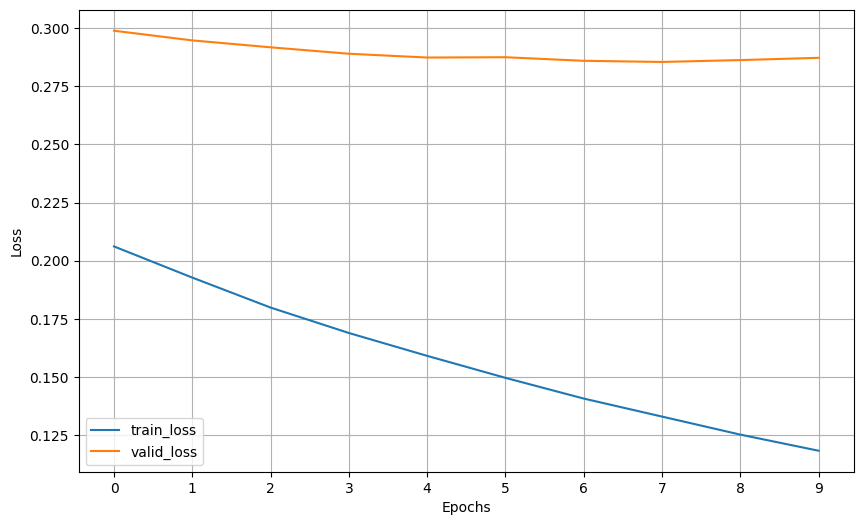

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(metrics['train_loss'],label='train_loss')
ax.plot(metrics['valid_loss'],label='valid_loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

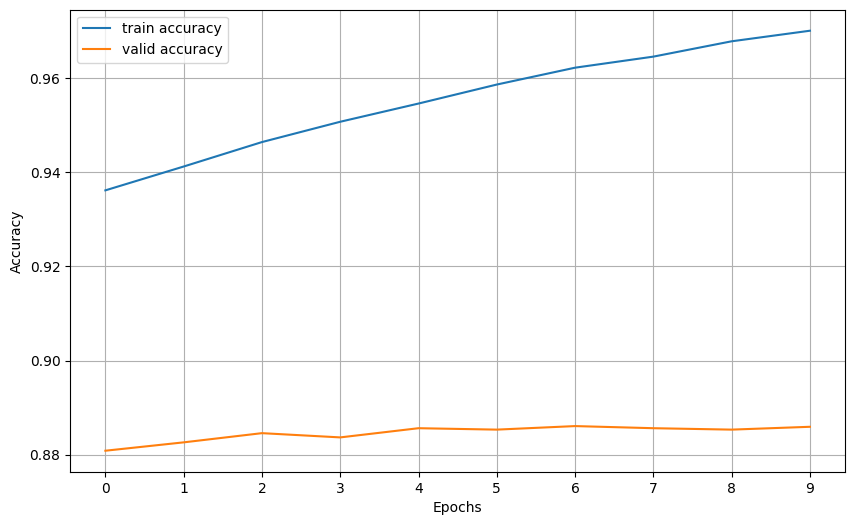

In [ ]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)
ax.plot(metrics['train_acc'],label="train accuracy")
ax.plot(metrics['valid_acc'],label="valid accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

Testing model with test data

In [ ]:
model.load_state_dict(torch.load("CBOW.pt"))
test_loss,test_acc=evaluate(
    test_batch_loader,
    model,
    criterion,
    device
)

Evaluating....: 100%|██████████| 49/49 [00:10<00:00,  4.82it/s]


In [ ]:
print(f"Test Loss:{test_loss:.3f},Test Accuracy:{test_acc:.3f}")

Test Loss:0.330,Test Accuracy:0.864


###7.  Testing model with new Sentence(Sentiment Analysis)

In [ ]:
def predict_sentiment(test,model,tokenizer,vocab,device):
    tokens=tokenizer(test)
    ids=vocab.lookup_indices(tokens)
    tensor=torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction=model(tensor).squeeze(dim=0)
    probability=torch.softmax(prediction,dim=-1)
    predicted_classes=prediction.argmax(dim=-1).item()
    predicted_probability=probability[predicted_classes].item()
    return predicted_classes,predicted_probability

In [ ]:
text="This movie is very good"

In [ ]:
predict_sentiment(text,model,tokenizer,vocab,device)

(1, 0.9999998807907104)

In [ ]:
text="This movie is terrible"
predict_sentiment(text,model,tokenizer,vocab,device)

(0, 1.0)